# Task 3 -  Quantum Circuit Simulator 







**Introduction**

Simulation of quantum systems on classical computers is a crucial task for the verification of quantum devices and the evaluation of quantum algorithms. 
The goal of this project is to implement a simple quantum circuit simulator. More specifically, a simulator that can perform the following tasks.

- initialize state

- read program, and for each gate:
    - calculate matrix operator
    - apply operator (modify state)
    
- perform multi-shot measurement of all qubits using weighted random technique

**Qubit**

The Qubit is the basic unit of quantum information and a fundamental piece for quantum computing. It is a two-state quantum-mechanical system, and can be represented by a linear superposition of two orthonormal basis states or basis vectors. The vector representation of a Qubit is the following: 

${\vert a\rangle =v_{0} \vert 0\rangle +v_{1} \vert 1\rangle \rightarrow {\begin{bmatrix}v_{0}\\v_{1}\end{bmatrix}}}$

Meanwhile a combined state of multiple qubits is the tensor product of their states. For example, the vector representation of two Qubits is:

${\displaystyle \vert ab\rangle =\vert a\rangle \otimes \vert b\rangle =v_{00}\vert 00\rangle +v_{01}\vert 01\rangle +v_{10}\vert 10\rangle +v_{11}\vert 11\rangle \rightarrow {\begin{bmatrix}v_{00}\\v_{01}\\v_{10}\\v_{11}\end{bmatrix}}}$



**Quantum gates**

In the quantum circuit model, a quantum logic gate is the basic quantum circuit operating in a determined number of qubits. Quantum gates are represented by unitary matrices. A quantum gate which acts on $n$ qubits is represented by a $2^n \times 2^n$ unitary matrix. The most common quantum gates operate with one or two qubits, just like their classical counterpart. 


The action of a quantum gate is calculated by multiplying the vector ${\vert a_1\rangle }$ by the matrix $U$ representing the quantum gate. The result is a new quantum state ${\vert a_2\rangle }$ calculated in the following way.

$U {\vert a_1\rangle } = {\vert a_2\rangle }$



**Numpy**

To represent qubits or quantum gates in a classical computer, the usual way is to use arrays or matrices of complex numbers. For example in python, we commonly implement these quantum entities with the help of powerful frameworks such as Numpy. This framework is designed to work with multi-dimensional arrays and matrices, and to perform high-level mathematical functions with them.
However, although Numpy is designed to take advantage of multiple CPU cores to perform its calculations, it neglects to take advantage of the powerful GPUs available today to speed up linear algebra operations.




**Pytorch**

PyTorch is an open source framework for machine learning. It is based on Torch and is commonly used for the development and research of deep neural networks. PyTorch was built for two objectives: Development of Deep Neural Networks, and Tensor computing (like NumPy but with acceleration via graphic processing units). 






**Proposed Approach**

To implement a quantum circuit simulator, we need a framework to efficiently perform calculations with multi-dimensional arrays (Such as Numpy or Pytorch). Next, to take advantage of the speed up provided by modern GPUs, we chose PyTorch to buld our architecture. We tested and developed our simulator using Google Colab and a Nvidia V100 as GPU. This GPU lets us work with circuits of 14 qubits before running out of memory. Finally, we implemented the possibility to run circuits in CPU mode as well.

# Quantum GPU Circuit Simulator

In [1]:
import torch
from torch.utils.data.sampler import WeightedRandomSampler
from collections import Counter, OrderedDict
import numpy as np
import math  

# We define the elemental quantum gates

#Hadamard
H_t = torch.tensor([
[1/np.sqrt(2), 1/np.sqrt(2)],
[1/np.sqrt(2), -1/np.sqrt(2)]
],  dtype=torch.cfloat)

#Pauli-X
X_t = torch.tensor([
[0, 1],
[1, 0]
],  dtype=torch.cfloat)

#Pauli-Y
Y_t = torch.tensor([
[0, -1j],
[1j, 0]
],  dtype=torch.cfloat)

#Pauli-Z
Z_t = torch.tensor([
[1, 0],
[0, -1]
],  dtype=torch.cfloat)

#Swap gate
Swap_t = torch.tensor([
[1, 0, 0, 0],
[0, 0, 1, 0],
[0, 1, 0, 0],
[0, 0, 0, 1]
],  dtype=torch.cfloat)

#Projector in 0
P0x0_t = torch.tensor([
[1, 0],
[0, 0]
],  dtype=torch.cfloat)

#Projector in 1
P1x1_t = torch.tensor([
[0, 0],
[0, 1]
],  dtype=torch.cfloat)

def kron(a, b):
    #return the kronecker product between two tensors
    assert a.dim() == b.dim()
    a_view_shape = []
    b_view_shape = []
    ab_view_shape = []
    for i in range(a.dim()):
        a_view_shape.append(a.size(i))
        a_view_shape.append(1)
        b_view_shape.append(1)
        b_view_shape.append(b.size(i))
        ab_view_shape.append(a.size(i) * b.size(i))
    return (a.reshape(a_view_shape) * 
            b.reshape(b_view_shape)).reshape(ab_view_shape)

def get_ground_state(num_qubits):
    # return vector of size 2**num_qubits with all zeroes except first element which is 1
    state = torch.zeros(1, 2**num_qubits, dtype=torch.cfloat)
    state[0,0] =  1+0j
    return state

def formulate_u3(parameters):
    #return the matrix definition of the u3 gate given theta, phi and lambda values
    theta = float(parameters["theta"])
    phi = float(parameters["phi"])
    lam = float(parameters["lambda"])

    cos = np.cos(theta / 2)
    sin = np.sin(theta / 2)

    u3 = torch.tensor([
    [cos, -np.exp(1j * lam) * sin],
    [np.exp(1j * phi) * sin, np.exp(1j * (phi + lam)) * cos]
    ],  dtype=torch.cfloat)

    # print(np.rint(u3.numpy()))
    return u3

def get_controlled_operator(total_qubits, 
                            gate_unitary,
                            control_qubits,
                            target_qubits, 
                            cuda = False):
  
    # return controlled unitary operator given gate and target qubits

    identity = torch.eye(2).cuda() if cuda else torch.eye(2)
    gate_unitary = gate_unitary.cuda() if cuda else gate_unitary
    projection0 = P0x0_t.cuda() if cuda else P0x0_t  
    projection1 = P1x1_t.cuda() if cuda else P1x1_t

    if control_qubits[0] == 0:
        current_gate1 = projection0
        current_gate2 = projection1
    elif target_qubits[0] == 0:
        current_gate1 = identity
        current_gate2 = gate_unitary
    else:
        current_gate1 = identity
        current_gate2 = identity    

    for i in range(1, total_qubits):

        if i in control_qubits:
            current_gate1 = kron(current_gate1, projection0)
            current_gate2 = kron(current_gate2, projection1)
        else: 
            current_gate1 = kron(current_gate1, identity)

            if i in target_qubits:
                current_gate2 = kron(current_gate2, gate_unitary)
            else:
                current_gate2 = kron(current_gate2, identity)

    return current_gate1 + current_gate2

def get_operator(total_qubits,
                 gate_unitary, 
                 target_qubits, 
                 cuda = False):
  
    # return unitary operator of given gate and target qubits

    identity = torch.eye(2).cuda() if cuda else torch.eye(2)
    gate_unitary = gate_unitary.cuda() if cuda else gate_unitary

    if target_qubits[0] == 0:
        current_gate = gate_unitary
    else:
        current_gate = identity


    for i in range(1, total_qubits):
        if i in target_qubits:
            current_gate = kron(current_gate, gate_unitary)
        else:
            current_gate = kron(current_gate, identity)

    return current_gate

def run_program(initial_state, program, params = None, cuda = False):
    
    # read program, and for each gate:
    #   - calculate matrix operator
    #   - multiply state with operator
    # return final state

    initial_state = initial_state.cuda() if cuda else initial_state
    number_of_qubits = initial_state.shape[1].bit_length() - 1
    for instruction in program:
        if instruction["gate"] == "h":
            current_operator = get_operator(number_of_qubits, H_t, 
                                            instruction["target"],
                                            cuda = cuda)
        elif instruction["gate"] == "x":
            current_operator = get_operator(number_of_qubits, X_t,
                                            instruction["target"],
                                            cuda = cuda)
        elif instruction["gate"] == "z":
            current_operator = get_operator(number_of_qubits, Z_t,
                                            instruction["target"],
                                            cuda = cuda)
        elif instruction["gate"] == "y":
            current_operator = get_operator(number_of_qubits, Y_t,
                                            instruction["target"],
                                            cuda = cuda)
        elif instruction["gate"] == "u3":
            current_gate = formulate_u3(instruction["params"] if params is None else params)
            current_operator = get_operator(number_of_qubits, current_gate,
                                            instruction["target"],
                                            cuda = cuda)
        elif instruction["gate"] == "cx":
            current_operator = get_controlled_operator(number_of_qubits, X_t,
                                                       instruction["control"],  
                                                       instruction["target"],
                                                       cuda = cuda)   

        initial_state = torch.matmul(initial_state, current_operator)

    return initial_state

def get_counts(state_vector, num_shots, print_results = False):
    
    # simply execute measure_all in a loop num_shots times and
    state_vector = state_vector.abs()**2
    sampler = WeightedRandomSampler(state_vector, num_shots)
    format = '{0:0' + str(state_vector.shape[1].bit_length() - 1) + 'b}'

    for idx in sampler:
        counter = Counter(idx)

    if print_results:
        print('{')
        for element in sorted(counter.items()) :
            print("\t\"" +  format.format(element[0]) + '\" : ' + str(element[1]))
        print('}')

    return counter

# Requirement 1



The simulator should initialize a state, read a program like the following one, and perform multi-shot measurement of all qubits using a weighted random technique.




```
[
  { "gate": "h", "target": [0] }, 
  { "gate": "cx", "target": [0, 1] }
  ...
]
```



**Deutsch-Jozsa Algorithm**

With the goal of demonstrating  the functionality of our simulator we implemented the famous Deutsch-Jozsa Algorithm. This was the first example of a quantum algorithm that performs better than its classical counterpart, and showed that there can be advantages to using a quantum computer as a computational tool. 

**Deutsch-Jozsa Problem**

We are given a hidden boolean function $f$, which takes as input a string of bits, and returns either $0$ or $1$:

$f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$

The feature of the given boolean function is that it is guaranteed to be balanced or constant. A constant function as the name implies, return $0$ or $1$ for any input. While the balanced function return $0$ for one half of the inputs and $1$ for the other half.

**Quantum Oracle**

Quantum Oracle is a black box which is commonly used in quantum algorithms. Often, the oracle is defined using a classical function $f: \{ 0,1 \}^{n} \rightarrow \{ 0,1 \}^{m}$ which takes an $n$-bit binary input and produces an $m$-bit binary output. Then, with the purpose of making the oracle a quantum operator, it needs to be an unitary operator. Then, we define the Oracle in the following way:

$ O ( \vert x\rangle \oplus \vert  y \rangle ) = \vert x\rangle \vert y \oplus f(x)\rangle$



**Quantum solution**

Using a quantum computer, we can solve this problem with 100% accuracy, with a single call of the boolean function. But for that, we need the boolean function $f$ implemented as a quantum oracle, which is going to map the state $\vert x\rangle \vert y\rangle$ to the state $\vert x\rangle \vert y \oplus f(x)\rangle$, where $\oplus$ is addition module 2. 


**Algorithm description**


1. The first step, is to prepare two quantum registers. The first is going to be a n-qubit register initialised to $|0\rangle$ and the second is a one-qubit reigster initialised to $|1\rangle$:

  $\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$

2. Apply the Hadamard gate all registers:

  $\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$

3. Apply the quantum oracle:

  $\vert \psi_2 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|f(x)\rangle - |1 \otimes f(x) \rangle \right)$

  $\vert \psi_2 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} (-1)^{f(x)}\vert x\rangle \left(|0\rangle - |1  \rangle \right)$

4. Apply Hadamard to each qubit of the first register:

  $\begin{aligned}
              \lvert \psi_3 \rangle 
                  & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                      \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                      \vert y \rangle \right] 
                  & 
  \end{aligned}$

  $\begin{aligned}
              \lvert \psi_3 \rangle 
                    & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
  \end{aligned}$

5. Measure the first register. The probability of measuring $\vert 0 \rangle ^{\otimes n} = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$ will be $1$ if $f(x)$ is constant and $0$ if $f(x)$ is balanced.

**Implementation**

In [2]:
import time

# First we define a register of 13 qubits, 1 ancilla, and 12 to work with the
# oracle function.

qubits = 13
my_qpu = get_ground_state(qubits)

# we apply the x gate to the last qubit for the oracle implementation
# then, we apply Hadamard gate to all qubits
# we apply CNOT to each qubit with the last register as target
# finally we perform Hadamard gate to all qubits again.

my_circuit = [
{ "gate": "x", "target":  [qubits - 1] },
{ "gate": "h", "target": range(0, qubits) },
{ "gate": "cx",  "control": [0], "target": [qubits - 1] },
{ "gate": "cx",  "control": [1], "target": [qubits - 1] },
{ "gate": "cx",  "control": [2], "target": [qubits - 1] },
{ "gate": "cx",  "control": [3], "target": [qubits - 1] },
{ "gate": "cx",  "control": [4], "target": [qubits - 1] },
{ "gate": "cx",  "control": [5], "target": [qubits - 1] },
{ "gate": "cx",  "control": [6], "target": [qubits - 1] },
{ "gate": "cx",  "control": [7], "target": [qubits - 1] },
{ "gate": "cx",  "control": [8], "target": [qubits - 1] },
{ "gate": "cx",  "control": [9], "target": [qubits - 1] },
{ "gate": "cx",  "control": [10], "target": [qubits - 1] },
{ "gate": "cx",  "control": [11], "target": [qubits - 1] },
{ "gate": "cx",  "control": [12], "target": [qubits - 1] },
{ "gate": "h", "target": range(0, qubits) }
]

#we run the program on CPU
start = time.time()
final_state = run_program(my_qpu, my_circuit, cuda = False)
end = time.time()
print('Exe time: ' + str(end - start))
counts = get_counts(final_state, 16000, print_results = True)

Exe time: 13.599707126617432
{
	"1111111111111" : 16000
}


In [3]:
#we run the program on CUDA
start = time.time()
final_state = run_program(my_qpu, my_circuit, cuda = True)
end = time.time()
print('Exe time: ' + str(end - start))
counts = get_counts(final_state, 16000, print_results = True)

Exe time: 6.139760732650757
{
	"1111111111111" : 16000
}



Measuring the qubits showed in both examples all ones, indicating the implemented balanced function. Moreover, the execution time when using GPUs reduced 64.55 times the same operation performed in CPU. This shows how we can speed up quantum circuit simulations with the help of modern GPUs and popular frameworks such as PyTorch. 



**CPU vs GPU**

To compare the performance of our GPU Quantum Circuit Simulator with its CPU version, we measured the execution time of each circuit for multiple qubits (1 to 11). Then, we plotted the obtained information to visualize identify the benefits of our GPU Quantum Simulator.





In [27]:
import time

QUBITS = 15

def test_simulator(cuda):
    execution_times = []

    for qubits in range(2, QUBITS):
        
        my_qpu = get_ground_state(qubits)

        my_circuit = [
        { "gate": "x", "target":  [qubits - 1] },
        { "gate": "h", "target": range(0, qubits) },
        { "gate": "cx",  "control": [0], "target": [qubits - 1] },
        { "gate": "h", "target": range(0, qubits) },
        { "gate": "z", "target":  [qubits - 1] },
        { "gate": "h", "target": range(0, qubits) },
        { "gate": "y", "target":  [qubits - 1] },
        { "gate": "h", "target": range(0, qubits) }
        ]

        start = time.time()
        final_state = run_program(my_qpu, my_circuit, cuda = cuda)
        end = time.time()

        execution_times.append(end - start)

    return execution_times


cuda_times = test_simulator(True)
cpu_times = test_simulator(False)

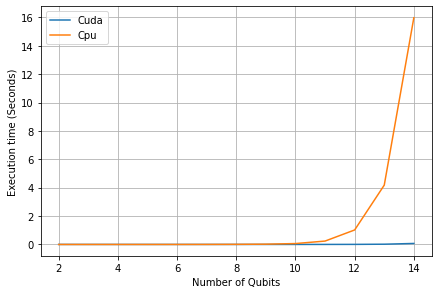

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
mu = 0
std = 1

x = np.linspace(start=-4, stop=4, num=100)
y = stats.norm.pdf(x, mu, std) 
line1 = plt.plot(range(2,QUBITS), cuda_times, label='Cuda')
line2 = plt.plot(range(2,QUBITS), cpu_times, label='Cpu')
plt.legend()
plt.tight_layout()
plt.grid()
plt.xlabel("Number of Qubits")
plt.ylabel("Execution time (Seconds)")

plt.show()

**Conclusion**

As proved in the aforementioned examples, our simulator is capable of performing quntum algorithms like the Deutsch-Jozsa algorithm. Moreover, our GPU Quantum Circuit Simulator performs better that its CPU version, proving that implemented simulators with the option of GPU acceleration could be a good asset to speed up quantum simulations.


# Requirement 2

Add support of parametric gates to the quantum circuit simulator.

Example of a program with parametric gates:

`{ "gate": "u3", "params": { "theta": 3.1415, "phi": 1.5708, "lambda": -3.1415 }, "target": [0] }`

which translates to the next operator.



```
[ 0+0j,  1+0j]

[ 0+1j,  0+0j]
```




**U3 Gate Formulation**

This gate is a generic single-qubit rotation with 3 Euler angles.

$
\begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\\begin{split}U3(\theta, \phi, \lambda) =
    \begin{pmatrix}
        \cos(\th)          & -e^{i\lambda}\sin(\th) \\
        e^{i\phi}\sin(\th) & e^{i(\phi+\lambda)}\cos(\th)
    \end{pmatrix}\end{split}\end{aligned}\end{align}
$

**Implementation**

In [6]:
qubits = 1
my_qpu = get_ground_state(qubits)

#we define the u3 gate
my_circuit = [
{ "gate": "u3", "params": { "theta": 3.1415, "phi": 1.5708, "lambda":  -3.1415}, "target": [0] }
]

#we print the final result and the operation matrix as well 
final_state = run_program(my_qpu, my_circuit, cuda = False)
counts = get_counts(final_state, 1000, print_results = True)


{
	"1" : 1000
}


# Requirement 3

Allow running variational quantum algorithms

In some applications, it is important to find the minimum eigenvalue of a matrix. In the case of chemistry, the minimum eigenvalue of a Hermitian matrix characterizing the molecule is the ground state energy of the system. This could be solved using a quantum phase estimation algorithm, however, implementing this kind of algorithms exceed the limits of hardware available in the NISQ era. Then, in 2014, Peruzzo et al. proposed a VQE, which uses much shallower circuits to solve the problem of the ground state energy of a molecule.

**Implementation**

In this example we use a single qubit variational form to solve a problem similar to the ground state energy estimation. We are given a random probability vector $\vec{x}$ and we wish to determine a possible parametrization for a single qubit. Such that when measured, the probability distribution is close to the determined before with $\vec{x}$.


In [7]:
import numpy as np
# np.random.seed(999990)
target_distr = np.random.rand(2)
# target_distr = np.array([0.9834016, 0.0165984])
#we define the target distribution
target_distr /= sum(target_distr)
NUM_SHOTS = 10000
print('Target dist: ', target_distr)

def get_var_form(params):

    # return the final count for the parameterized circuit given 3 euler angles 

    qubits =1
    my_qpu = get_ground_state(qubits)
    my_circuit = [
    { "gate": "u3", "params":
     { "theta": None, "phi": None, "lambda": None }, "target": [0] }
    ]

    final_state = run_program(my_qpu, my_circuit, 
                              {"theta": params[0],
                               "phi": params[1], 
                               "lambda": params[2]}, 
                              cuda = True)
    return final_state

def get_probability_distribution(counts):

    # return the probability distribution given a measaurement of multiple shoots

    output_distr = [v[1] / NUM_SHOTS for v in sorted(counts.items())]
    if len(output_distr) == 1:
        output_distr.append(1 - output_distr[0])

    return output_distr

def objective_function(params):

    # Calculate the cost as the distance between the output distribution and the target distribution

    final_state = get_var_form(params)
    result = get_counts(final_state, NUM_SHOTS)
    output_distr = get_probability_distribution(result)
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2)])
    return cost

Target dist:  [0.20415248 0.79584752]


In [9]:
!pip install qiskit ipywidgets &> /dev/null

In [10]:
from qiskit.aqua.components.optimizers import COBYLA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=1000, tol=0.00001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

# Obtain the output distribution using the final parameters
final_state = get_var_form(ret[0])
result = get_counts(final_state, NUM_SHOTS)
output_distr = get_probability_distribution(result)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

Target Distribution: [0.20415248 0.79584752]
Obtained Distribution: [0.2058, 0.7942]
Output Error (Manhattan Distance): 0.012304962473901115
Parameters Found: [4.07209616 1.57452526 1.78357923]


**Conclusion**

Machine learning approaches based in classical von Neumann architecture have been widely popular in either academic or industrial domains. Now, researchers have tried to implement machine learning approaches in the recent available quantum computers. However, it is hard to simulate classical deep learning models due to the intractability of deep quantum circuits. Thus, a new approach for feasible quantum machine learning is required. Variational quantum circuits were the response to that need and one of the key ingredients to implement them, is a parametrized quantum circuit, such as the one we can build with U3 Gates. U3 gates let us build Quantum Machine Learning solutions, at least for the near term NISQ devices which are available right now.
